# Analise de intervencoes do parlamento

## 1.Recolha e formatação de dados

Com base nos dados abertos disponibilizados no site da assembleia da republica, tive a ideia de investigar as varias [intervencoes](http://www.parlamento.pt/Cidadania/Paginas/DAIntervencoes.aspx) correspondentes a ultima legislatura. 

Começamos por importar alguns modulos importantes: 

In [1]:
from __future__ import division
import json
import nltk
import pandas as pd
from pprint import pprint
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.stem import SnowballStemmer
plt.style.use('ggplot')
%matplotlib inline

Após downloadar os dados no formato json, transferimos para um dictionario chamado `interventions`.

In [2]:
with open('data/IntervencoesXIV.json',encoding="utf8", mode='r') as data_file:    
    data = json.load(data_file)
    
interventions = data['ArrayOfPt_gov_ar_objectos_intervencoes_DadosPesquisaIntervencoesOut']['pt_gov_ar_objectos_intervencoes_DadosPesquisaIntervencoesOut']
print('O dictionario tem {} intervencoes.'.format(len(interventions)))

O dictionario tem 1919 intervencoes.


Vamos fazer um print da primeira intervenção:

In [3]:
pprint(interventions[0])

{'actividadeId': '114499',
 'actividadesRelacionadas': {'id': '114499', 'tipo': 'Disc. Iniciativas'},
 'dataReuniaoPlenaria': '2020-02-27',
 'deputados': {'GP': 'PSD', 'idCadastro': '132', 'nome': 'RUI RIO'},
 'faseSessao': 'POD',
 'idDebate': '35210',
 'iniciativas': {'pt_gov_ar_objectos_intervencoes_IniciativasOut': {'fase': 'Votação '
                                                                            'do '
                                                                            'recurso '
                                                                            'da '
                                                                            'decisão '
                                                                            'do '
                                                                            'PAR',
                                                                    'id': '44258',
                                                                    'tipo'

O formato das intervenções variam muito. Algumas têm 3 campos, outras 12. No entanto, os seguintes campos vão ser os essenciais: 

In [4]:
must_have_fields = ['deputados', 'dataReuniaoPlenaria', 'sumario']

Damos um nome as varias colunas para a nossa tabela de dados: 

In [5]:
pandas_data = [['id_debate', 'date', 'phase', 'speaker', 'political_party', 'summary_text', 'intervention_type']]

Adicionamos as intervenções a nossa "pandas dataframe".

In [6]:
# initialize counters
total = 0
retrieved = 0

# loop over list
for intervention in interventions:
    total += 1
    if all(x in intervention.keys() for x in must_have_fields):
        # define fields
        debate_id = intervention['idDebate']
        date = intervention['dataReuniaoPlenaria']
        phase = intervention['faseSessao']
        speaker = intervention['deputados']['nome']
        political_party = intervention['deputados']['GP']
        summary_text = intervention['sumario']
        intervention_type_text = intervention['tipoIntervencao']
        
        # add to pandas list
        pandas_data += [[debate_id, date, phase, speaker, political_party, summary_text, intervention_type_text]] 
        retrieved += 1

Com base neste criterio de "tem de ter estes campos", acabamos por nao perder muito..

In [7]:
print ('Intervencoes parsadas: ', total)
print ('Intervencoes que foram aceites: ', retrieved)
print ('Perdemos {}%.'.format(round(retrieved/total,2)))

Intervencoes parsadas:  1919
Intervencoes que foram aceites:  1694
Perdemos 0.88%.


Finalment podemos criar um pandas dataframe com todas as intervenções.

In [8]:
assembleia = pd.DataFrame(pandas_data[1:], columns=pandas_data[0])
assembleia = assembleia.drop_duplicates() # limpamos qualquer intervenção duplicada. 

## 2.Analise preliminar

Vamos ver o que obtemos neste dataframe: 

In [9]:
assembleia.head()

,id_debate,date,phase,speaker,political_party,summary_text,intervention_type
0,35210,2020-02-27,POD,RUI RIO,PSD,Agravação das molduras penais privativas de li...,Declaração de voto
1,35199,2020-02-20,POD,HUGO CARNEIRO,PSD,Define e regula as condições em que a antecipa...,Declaração de voto
2,35199,2020-02-20,POD,PAULO LEITÃO,PSD,Define e regula as condições em que a antecipa...,Declaração de voto
3,35199,2020-02-20,POD,ANTÓNIO MALÓ DE ABREU,PSD,Define e regula as condições em que a antecipa...,Declaração de voto
4,35199,2020-02-20,POD,PEDRO CEGONHO,PS,Define e regula as condições em que a antecipa...,Declaração de voto


In [10]:
assembleia.shape
print ('Temos {} colunas e {} linhas.'.format(assembleia.shape[1], assembleia.shape[0]))

Temos 7 colunas e 1477 linhas.


Tipos de dados? 

In [11]:
assembleia.dtypes

id_debate            object
date                 object
phase                object
speaker              object
political_party      object
summary_text         object
intervention_type    object
dtype: object

Quais os diferentes partidos? 

In [12]:
party_names = list(assembleia.political_party.unique())
print (party_names)
party_colors_rgb = [(255, 86, 231), (255, 0, 1), (255, 142, 2), (0, 136, 216), (1, 117, 0), (124, 10, 11), (0, 117, 117)]

['PSD', 'PS', 'PAN', 'CH', 'BE', 'CDS-PP', 'IL', 'PCP', 'L', 'PEV', 'Ninsc']


Que tipos de intervenções existem na base de dados? 

In [13]:
for tipo_de_intervencao in list(assembleia.intervention_type.unique()):
    print (tipo_de_intervencao)

Declaração de voto
Declaração politica
Defesa da honra
Explicações
Interpelação à mesa
Intervenção
Leitura
Pedido de esclarecimento
Pergunta


Os anos das intervenções? 

In [14]:
assembleia.date.str.slice(0, 4).value_counts()

2019    873
2020    604
Name: date, dtype: int64

Que tipos de intervenções acontecem mais? 

In [15]:
assembleia.intervention_type.value_counts(normalize=True)

Intervenção                 0.503047
Pedido de esclarecimento    0.209208
Declaração de voto          0.157752
Pergunta                    0.050102
Declaração politica         0.029113
Leitura                     0.026405
Interpelação à mesa         0.014218
Explicações                 0.007448
Defesa da honra             0.002708
Name: intervention_type, dtype: float64

## 3.Partidos  
### 3.1.Que partidos falam mais? 

De forma a manter isto o mais simples possivel, vamos limitar os nosso resultados a intervenções do tipo `Intervenção`, que já são por si, 50%. 

Alguns tipos de declarações são limitados ao partido no governo, e existem outras coisinhas desse genero..

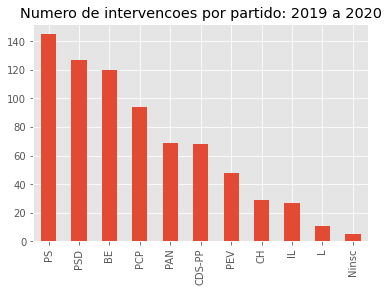

In [16]:
plt.title('Numero de intervencoes por partido: 2019 a 2020')
assembleia[(assembleia.intervention_type==u'Intervenção')].political_party.value_counts(normalize=False).plot(kind='bar')

Quem fala mais aparenta ser o PSD, seguido do PS. O BE e o PCP parecem bastante equilibrados.

Olhemos agora para o ano de 2016:

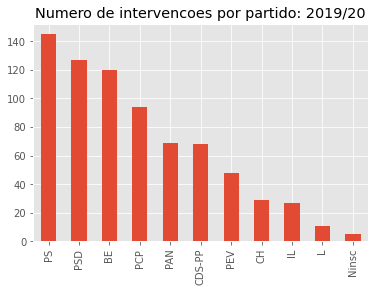

In [17]:
plt.title('Numero de intervencoes por partido: 2019/20')
assembleia[(assembleia.intervention_type==u'Intervenção')
           & (assembleia['date'] > '2019-01-01')
           & (assembleia['date'] < '2020-12-30')].political_party.value_counts(normalize=False).plot(kind='bar')

As tendencias aparentam ser as mesmas.

### 3.2.Que tipos de intervenções é que os partidos fazem? 

Em percentagens e valores numericos. 

In [18]:
assembleia.groupby('intervention_type').political_party.value_counts(normalize=True)

intervention_type   political_party
Declaração de voto  PS                 0.278970
                    PAN                0.227468
                    PSD                0.197425
                    CDS-PP             0.111588
                    BE                 0.090129
                                         ...   
Pergunta            PEV                0.094595
                    CDS-PP             0.081081
                    CH                 0.081081
                    IL                 0.081081
                    L                  0.040541
Name: political_party, Length: 65, dtype: float64

### 3.3.Intervenções ao longo do tempo

Quanto é que os partidos falam ao longo do tempo? Como exemplo, o ano de 2016 e 2017..

In [19]:
'''
plt.figure(figsize=(30, 15))
plt.title('Intervencoes ao longo do tempo: 2019/20')
for index, partido in enumerate(party_names):
    assembleia[(assembleia.intervention_type==u'Intervenção') 
               & (assembleia.political_party==partido)
               & (assembleia['date'] > '2019-01-01')
               & (assembleia['date'] < '2019-12-31') ].groupby(assembleia.date).intervention_type.count().plot(label=partido, color=tuple(e/255 for e in party_colors_rgb[index]))
    
plt.legend()
'''

"\nplt.figure(figsize=(30, 15))\nplt.title('Intervencoes ao longo do tempo: 2019/20')\nfor index, partido in enumerate(party_names):\n    assembleia[(assembleia.intervention_type==u'Intervenção') \n               & (assembleia.political_party==partido)\n               & (assembleia['date'] > '2019-01-01')\n               & (assembleia['date'] < '2019-12-31') ].groupby(assembleia.date).intervention_type.count().plot(label=partido, color=tuple(e/255 for e in party_colors_rgb[index]))\n    \nplt.legend()\n"

### 3.4.Wordcloud de um partido

Criamos algumas funções que podem ajudar.

In [20]:
def tokenized_text(party):
    """
    Returns the token list of all of the party interventions
    """

    # vamos buscar dados a dataframe
    interventions_of_party = assembleia.loc[(assembleia.political_party == party) &
                   (assembleia.intervention_type == u'Intervenção')].drop_duplicates(subset='summary_text', keep="last") # tabela com intervenções
    interventions_of_party = interventions_of_party.drop_duplicates() # limpar duplicate rows se existirem ainda

    # agregamos dados da dataframe
    party_text = '' # string vazia onde vamos por todos os textos sumarios 
    for index, row in interventions_of_party.iterrows():
        party_text = party_text + ' ' + row['summary_text'] # adiciona todas as linhas de intervenções
        
    # limpamos dados da dataframe
    party_text_lower = party_text.lower() # lower case everything
    party_text_tokens = nltk.word_tokenize(party_text_lower) # tokenize text
    party_text_tokens = [token.lower() for token in party_text_tokens if token.isalpha()] # remove punctuation and numbers
    party_text_tokens = [token for token in party_text_tokens 
                         if token not in nltk.corpus.stopwords.words('portuguese')] # remove stopwords
    black_words = ['governo', 'recomenda', 'lei', u'código', u'alteração',
                   'regime', 'medidas', 'sobre', 'altera', 'aprova', u'adoção',
                   'estabelece', 'procede', 'apoio', 'processo', 'solicitam']
    party_text_tokens = [token for token in party_text_tokens if token not in black_words] # remove black listed words
    
    return party_text_tokens

In [21]:
def most_common_words(party, size_of_list):
    """
    Returns a list of the most commonly used words in a list of tokens
    """
    party_text_tokens = tokenized_text(party)
    fd = nltk.FreqDist(party_text_tokens)
    for word in fd.most_common(size_of_list):
        print (word[0], word[1])

In [22]:
def word_cloud(party):
    """
    Returns a wordcloud from tokens
    """
    party_text_tokens = tokenized_text(party)
    clean_party_text = " ".join(party_text_tokens)
    wordcloud = WordCloud(max_font_size=40).generate(clean_party_text)
    plt.figure()
    plt.title(party)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

E analisamos os dados para todos os partidos:

In [23]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

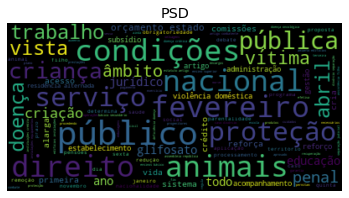

doença 19
condições 13
animais 12
nacional 12
fevereiro 12
proteção 10
trabalho 9
vista 9
abril 9
anos 9


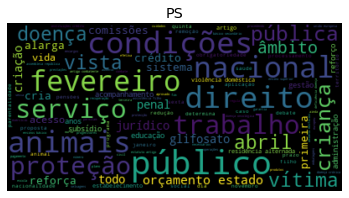

doença 19
condições 13
animais 12
nacional 12
fevereiro 12
trabalho 10
proteção 10
vista 9
abril 9
estado 9


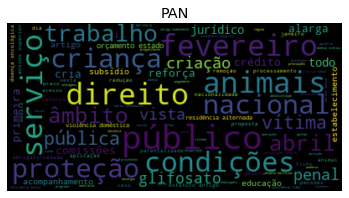

doença 17
animais 12
fevereiro 12
condições 11
nacional 10
proteção 10
trabalho 9
públicos 8
âmbito 8
crédito 8


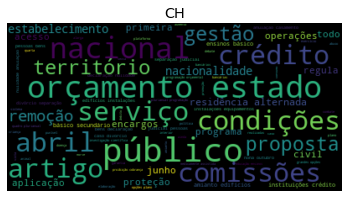

estado 9
crédito 8
orçamento 8
declaração 7
nacional 7
públicos 7
amianto 7
comissões 6
condições 6
abril 6


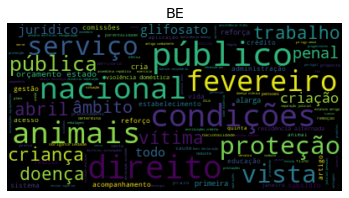

doença 19
condições 13
animais 12
nacional 12
fevereiro 12
proteção 10
vista 10
trabalho 9
abril 9
estado 9


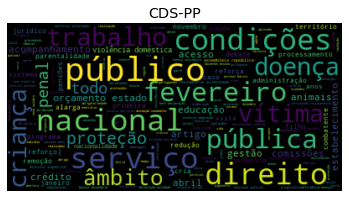

doença 14
nacional 13
condições 12
fevereiro 10
trabalho 9
pública 9
públicos 8
serviço 8
âmbito 8
crédito 8


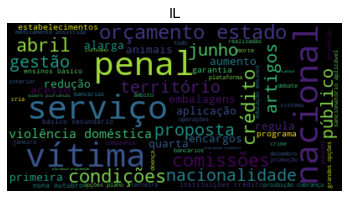

crédito 8
estado 8
penal 7
nacional 7
orçamento 7
comissões 6
condições 6
abril 6
violência 6
aplicável 5


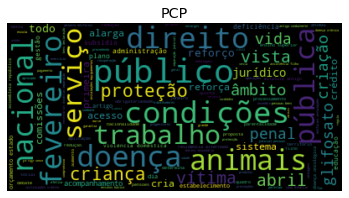

doença 19
condições 14
animais 12
nacional 12
fevereiro 12
trabalho 10
proteção 10
pessoas 10
vista 9
público 9


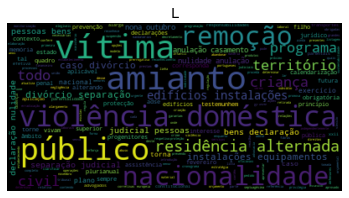

violência 7
amianto 7
doméstica 6
edifícios 6
vítimas 5
remoção 5
residência 5
alternada 5
caso 5
pessoas 5


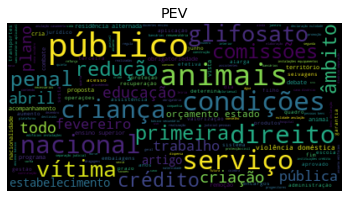

animais 12
públicos 9
condições 9
crédito 8
nacional 8
violência 8
anos 7
glifosato 7
amianto 7
superior 7


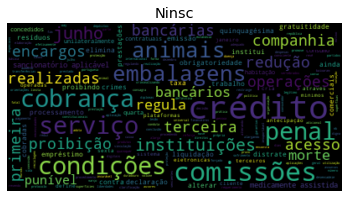

crédito 8
comissões 6
penal 5
condições 5
cobrança 5
animais 4
embalagens 4
instituições 4
junho 4
serviços 4


In [24]:
for party in party_names:
    word_cloud(party)
    most_common_words(party, 10)

## 4.Deputados

### 4.1.Deputados que mais falam

Nest instancia, vamos analisar os deputados que mais intervêem em cada ano:

In [25]:
def top_speakers(year, number_of_speakers):
    print ('-' * 19, 'TOP SPEAKERS FOR YEAR {}'.format(year), '-' * 20)
    print (assembleia[(assembleia.intervention_type==u'Intervenção') 
                   & (assembleia['date'] > '{}-01-01'.format(year))
                   & (assembleia['date'] < '{}-01-01'.format(year + 1)) ].speaker.value_counts(normalize=False)[0:number_of_speakers])
    
for year in range(2019, 2020):
    top_speakers(year, 30)
    print ('')

------------------- TOP SPEAKERS FOR YEAR 2019 --------------------
JOSÉ LUÍS FERREIRA           15
ANA RITA BESSA               14
MARIANA SILVA                13
INÊS DE SOUSA REAL           13
CRISTINA RODRIGUES           12
ANDRÉ VENTURA                12
CECÍLIA MEIRELES             11
TELMO CORREIA                10
JOACINE KATAR MOREIRA        10
BEBIANA CUNHA                10
ANTÓNIO FILIPE               10
JOÃO COTRIM DE FIGUEIREDO     9
DIANA FERREIRA                8
PEDRO FILIPE SOARES           8
JOSÉ MOURA SOEIRO             8
ANA MESQUITA                  7
JOÃO DIAS                     7
JOÃO OLIVEIRA                 6
JOÃO PINHO DE ALMEIDA         6
JOANA MORTÁGUA                5
BRUNO DIAS                    5
PAULA SANTOS                  5
MOISÉS FERREIRA               5
ANDRÉ SILVA                   5
NELSON PERALTA                4
SANDRA CUNHA                  4
ISABEL PIRES                  4
LUÍS MONTEIRO                 3
RICARDO VICENTE               3
ALMA

### 4.2.Deputados que menos falam

E os que menos falam.

In [26]:
def top_speakers(year, number_of_speakers):
    print ('-' * 19, 'BOTTOM SPEAKERS FOR YEAR {}'.format(year), '-' * 20)
    print (assembleia[(assembleia.intervention_type==u'Intervenção') 
                   & (assembleia['date'] > '{}-01-01'.format(year))
                   & (assembleia['date'] < '{}-01-01'.format(year + 1)) ].speaker.value_counts(normalize=False)[-number_of_speakers:])
    
for year in range(2019, 2020):
    top_speakers(year, 20)
    print ('')
    
    


------------------- BOTTOM SPEAKERS FOR YEAR 2019 --------------------
RUI RIO                   1
JOÃO PAULO CORREIA        1
RICARDO LEÃO              1
HUGO PATRÍCIO OLIVEIRA    1
CATARINA MARCELINO        1
NUNO MIGUEL CARVALHO      1
EURÍDICE PEREIRA          1
CLÁUDIA ANDRÉ             1
JORGE SALGUEIRO MENDES    1
MIGUEL MATOS              1
JOÃO GOUVEIA              1
ANTÓNIO CUNHA             1
CARLOS PEREIRA            1
LUÍS CAPOULAS SANTOS      1
PEDRO RODRIGUES           1
CARLA MADUREIRA           1
RAUL MIGUEL CASTRO        1
MARINA GONÇALVES          1
ISABEL MEIRELES           1
CLÁUDIA SANTOS            1
Name: speaker, dtype: int64



### 4.3.Wordcloud de deputados

In [27]:
def tokenized_text(speaker):
    """
    Returns the token list of all of the speaker interventions
    """

    # vamos buscar dados a dataframe
    interventions_of_speaker = assembleia.loc[(assembleia.speaker == speaker) &
                   (assembleia.intervention_type == u'Intervenção')].drop_duplicates(subset='summary_text', keep="last") # tabela com intervenções
    interventions_of_speaker = interventions_of_speaker.drop_duplicates() # limpar duplicate rows se existirem ainda

    # agregamos dados da dataframe
    speaker_text = '' # string vazia onde vamos por todos os textos sumarios 
    for index, row in interventions_of_speaker.iterrows():
        speaker_text = speaker_text + ' ' + row['summary_text'] # adiciona todas as linhas de intervenções
        
    # limpamos dados da dataframe
    speaker_text_lower = speaker_text.lower() # lower case everything
    speaker_text_tokens = nltk.word_tokenize(speaker_text_lower) # tokenize text
    speaker_text_tokens = [token.lower() for token in speaker_text_tokens if token.isalpha()] # remove punctuation and numbers
    speaker_text_tokens = [token for token in speaker_text_tokens 
                         if token not in nltk.corpus.stopwords.words('portuguese')] # remove stopwords
    black_words = ['governo', 'recomenda', 'lei', u'código', u'alteração',
                   'regime', 'medidas', 'sobre', 'altera', 'aprova', u'adoção',
                   'estabelece', 'procede', 'apoio', 'processo', 'solicitam']
    speaker_text_tokens = [token for token in speaker_text_tokens if token not in black_words] # remove black listed words
    
    return speaker_text_tokens

In [28]:
def word_cloud(speaker):
    """
    Returns a wordcloud from tokens
    """
    party_text_tokens = tokenized_text(speaker)
    print(party_text_tokens)
    clean_party_text = " ".join(party_text_tokens)
    wordcloud = WordCloud(max_font_size=40).generate(clean_party_text)
    plt.figure()
    plt.title(speaker)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

['grandes', 'opções', 'plano', 'orçamento', 'estado', 'quadro', 'plurianual', 'programação', 'orçamental', 'anos', 'encerramento', 'debate', 'programa', 'xxii', 'constitucional']


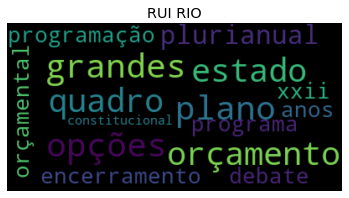

['institui', 'obrigatoriedade', 'gratuitidade', 'emissão', 'distrate', 'declaração', 'liquidação', 'empréstimo', 'elimina', 'comissões', 'cobradas', 'processamento', 'prestações', 'crédito', 'proibindo', 'ainda', 'instituições', 'crédito', 'alterar', 'unilateralmente', 'condições', 'contratuais', 'créditos', 'concedidos', 'consumo', 'quarta', 'junho', 'institui', 'obrigatoriedade', 'gratuitidade', 'emissão', 'distrate', 'declaração', 'liquidação', 'empréstimo', 'elimina', 'comissões', 'cobradas', 'processamento', 'prestações', 'crédito', 'proibindo', 'ainda', 'instituições', 'crédito', 'alterar', 'unilateralmente', 'condições', 'contratuais', 'créditos', 'concedidos', 'habitação', 'terceira', 'junho', 'consagra', 'proibição', 'cobrança', 'encargos', 'instituições', 'crédito', 'operações', 'realizadas', 'plataformas', 'eletrónicas', 'operadas', 'terceiros', 'primeira', 'janeiro', 'cria', 'sistema', 'acesso', 'conta', 'básica', 'universal', 'elaboração', 'orientações', 'política', 'comis

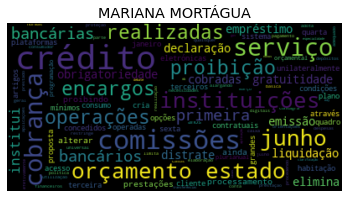

['repúdio', 'atitudes', 'caráter', 'racista', 'alvo', 'futebolista', 'marega', 'grandes', 'opções', 'plano', 'orçamento', 'estado', 'quadro', 'plurianual', 'programação', 'orçamental', 'osanos', 'encerramento', 'debate', 'programa', 'xxii', 'constitucional']


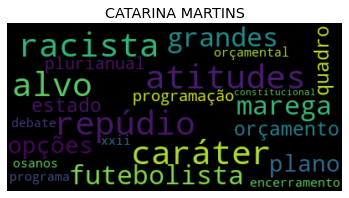

In [33]:
speakers = [u'RUI RIO', u'MARIANA MORTÁGUA', 'CATARINA MARTINS']
#partys = ['CH']

for speaker in speakers: 
    word_cloud(speaker)


#for speaker, party in speakers, partys: 
#    word_cloud(speaker,party)